In [2]:
from glob import glob
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns

def fixpath(path):
    if path.startswith("C:"): return "/mnt/c/" + path.replace("\\", "/")[3:]
    else:
        pass
    return path

plt.rc('lines', linewidth=0.75)

output_dir = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_hydro\base_COPPER_output")
os.chdir(output_dir)

dirs = glob(f'{output_dir}/*x*/', recursive=True)

scens = []
for dir in dirs:
    scen = dir.split('/')[-2]
    scens.append(scen)

scens

In [3]:
caps_BC = pd.DataFrame()
caps_AB = pd.DataFrame()
for dir in dirs:
    os.chdir(dir)
    cap = pd.read_excel('Results_summary.xlsx', sheet_name='ABA_generation_mix', index_col=0) 
    cap_BC = cap.iloc[:,26]
    cap_AB = cap.iloc[:,27]
    caps_BC[f"BC_{dir.split('/')[-2]}"] = cap_BC
    caps_AB[f"AB_{dir.split('/')[-2]}"] = cap_AB
    os.chdir(output_dir)

base_cap = pd.read_excel(fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_hydro\base_COPPER_output\base_caps.xlsx"))
base_cap[['province', 'excess', 'gen_type']] = base_cap['ABA'].str.split('.',expand=True)
base_cap = base_cap.drop(['ABA','excess'], axis=1)
base_cap_BC = base_cap[base_cap['province'] == 'British Columbia']
base_cap_BC = base_cap_BC.drop(['province'], axis=1)
base_cap_BC = base_cap_BC.set_index('gen_type')
base_cap_AB = base_cap[base_cap['province'] == 'Alberta']
base_cap_AB = base_cap_AB.drop(['province'], axis=1)
base_cap_AB = base_cap_AB.set_index('gen_type')

caps = pd.concat([base_cap_BC.transpose(), caps_BC.transpose(), base_cap_AB.transpose(), caps_AB.transpose()], axis=0)
caps.replace(np.nan, 0, inplace=True)
caps.to_csv('caps.csv')

In [5]:
#General plot settings

gen_types = {
    'hydro': 'Hydro',
    'wind': 'Wind',
    'solar': 'Solar',
    'gasCC': 'Gas CC',
    'gasccs': 'Gas CCS',
    'coalccs': 'Coal CCS',
    'SMR': 'SMR',
    'nuclear': 'Nuclear',
    'gasSC': 'Gas SC',
    'coal' : 'Coal',
    'diesel': 'Diesel',
    'biomass': 'Biomass',
    'PHS': 'PHS',
    'LB': 'LB'
}

colors = {
    'hydro': '#a1c5ff',
    'wind': '#a9d6ae',
    'solar': '#fcfba9',
    'Wind': '#a9d6ae',
    'gasCC': '#a3a3a3',
    'gasccs': '#a3a3a3',
    'coalccs': '#a3a3a3',
    'SMR': '#a36594',
    'nuclear': '#664264',
    'gasSC': '#454545',
    'coal' : '#0d0d0d',
    'diesel': '#707070',
    'biomass': '#a8b3a2',
    'PHS': '#c4fcff',
    'LB': '#b8c3fc'
}

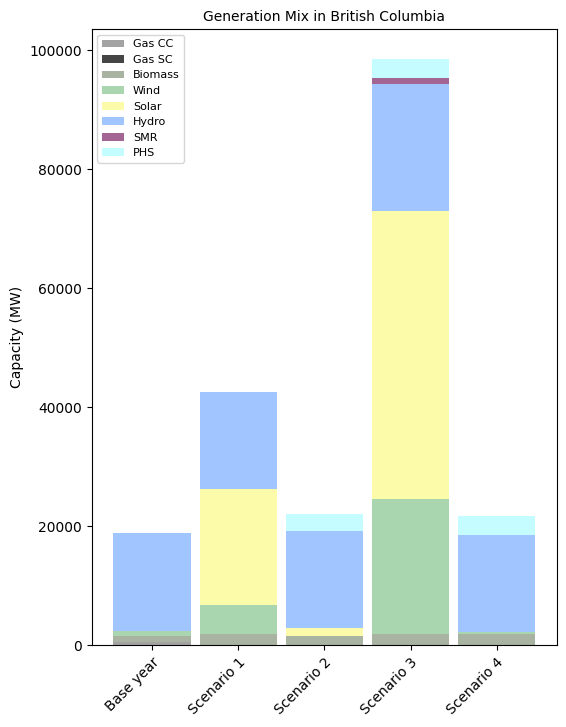

In [40]:
#Bar chart of generation mix in BC

BC_ch = caps.iloc[0:5]
BC_ch = BC_ch.loc[:, (BC_ch != 0).any(axis=0)]
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Generation Mix in British Columbia', fontsize=10)
ax.set_ylabel('Capacity (MW)', fontsize=10)
scen_labels = ['Base year', 'Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
BC_ch.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.9)
ax.set(xticklabels=scen_labels)
ax.legend(loc='upper left', fontsize=8, labels=[gen_types[i] for i in BC_ch.columns])
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=10, rotation_mode="anchor")
plt.savefig('BC_ch.png', dpi=300, bbox_inches='tight')

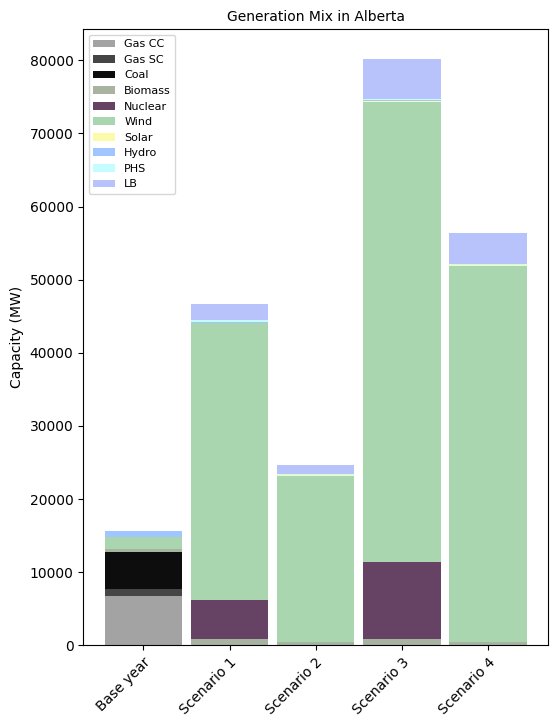

In [41]:
#Bar chart of generation mix in AB

AB_ch = caps.iloc[5:10]
AB_ch = AB_ch.loc[:, (AB_ch != 0).any(axis=0)]
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Generation Mix in Alberta', fontsize=10)
ax.set_ylabel('Capacity (MW)', fontsize=10)
scen_labels = ['Base year', 'Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
AB_ch.plot(kind='bar', stacked=True, ax=ax, color=colors, align='center', width=0.9)
ax.set(xticklabels=scen_labels)
ax.legend(loc='upper left', fontsize=8, labels=[gen_types[i] for i in AB_ch.columns])
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=10, rotation_mode="anchor")
plt.savefig('AB_ch.png', dpi=300, bbox_inches='tight')

In [62]:
trans_list = []
for dir in dirs:
    os.chdir(dir)
    trans = pd.read_excel('Results_summary.xlsx', sheet_name='New_installed_transmission', index_col=0)
    ex_trans = pd.read_csv(fixpath(r"C:\Users\smoha\Documents\git\copper\COPPER7\extant_transmission.csv"))
    trans_list.append(round(trans.iloc[0,:].sum() + trans.iloc[2,:].sum() + ex_trans.iloc[0,7] + ex_trans.iloc[2,7],3))
    os.chdir(output_dir)
    
trans_scen = pd.DataFrame(trans_list, index=[i.split('/')[-2] for i in dirs], columns=['transmission (MW)'])
trans_scen = trans_scen.transpose()
trans_scen.insert(0, column='base year', value=2200)
trans_scen.to_excel('trans_scen.xlsx')